# CS-3240 MACHINE LEARNING - PROJECT - JULIUS ZETTELMEIER


In [1]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt # library providing tools for plotting data
import glob #necessairy to import all csv files conveniently
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error    # function to calculate mean squared error
from sklearn.model_selection import train_test_split 

# Importing and preparing the Raw data:

In [2]:
path = r'C:\Users\zette\Documents\CS3240MachineLearning_project\DataSets_workouts'
file_names = glob.glob(path + "/*.csv") # importing all file names as list

index = 1
RAWDATA = pd.DataFrame()

for filename in file_names:
    new_activity = pd.read_csv(filename,header = 0) # importing csv of one activity 
    new_activity['Activity Number'] = index # appending new columnn with activity index
    
    new_activity = new_activity.iloc[1:-2 , :] # removing last, second to last (summary row of the activity -> not required) 
                                               # and first row, for reasons described in the report, La
    
    new_activity['Total Ascent'].replace('--', 0.1, inplace=True) # replacing the '--' strings in altitude with integer of 0.01
                                                                    # 0.1 instead of 0 because of feature construction
    new_activity['Total Ascent'] = new_activity['Total Ascent'].astype(int)
    new_activity['Previous Ascent'] = new_activity['Total Ascent'].shift(1)
    new_activity['Previous Ascent'] = new_activity['Previous Ascent'].fillna(.1)  
    new_activity['Previous Ascent'].replace(0.0, 0.1, inplace=True) # replacing the remaining 0 values with 0.1
    new_activity['Cumulative Ascent'] = new_activity['Total Ascent'].cumsum() # Appending "Cumulative Ascent" column
    new_activity['Cumulative Distance'] = new_activity['Distance'].cumsum() # Appending"Cumulative Distance" column
   

    # Coverting the pace format from min:sec to xx,xx min
    pace_split = new_activity['Avg Pace'].str.split(':', expand = True)
    minutes = pace_split[0].astype(float)
    seconds = pace_split[1].astype(float)/60 # in minutes
    minutes = minutes + seconds
    new_activity['Avg Pace'] = minutes
    
    # Shifting Avg Pace
    new_activity['Cumulative Avg Pace'] = new_activity['Avg Pace'].cumsum()/new_activity['Cumulative Distance']
    new_activity['Previous Avg Pace'] = new_activity['Avg Pace'].shift(1)
    new_activity['Previous Avg Pace'] = new_activity['Previous Avg Pace'].fillna(0.1)
   

    # Cumulatice Avg Heart Rate
    new_activity['Cumulative Avg HR'] = new_activity['Avg HR'].cumsum()/new_activity['Cumulative Distance']

    # Data cleaning
    new_activity.drop(new_activity.loc[new_activity['Avg Pace'] >= 6].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Cumulative Avg Pace'] >= 6.5].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Cumulative Ascent'] >= 80].index, inplace=True)
    new_activity.drop(new_activity.loc[new_activity['Previous Avg Pace'] == 0.1].index, inplace=True)
    RAWDATA =  pd.concat([RAWDATA, new_activity],ignore_index=True); # appending read csv to RAWDATA data frame
       
    index = index+1

df = RAWDATA.drop(['Time', 'Cumulative Time','Distance','Max HR','Total Descent', 'Avg Run Cadence',\
                'Avg Stride Length','Calories','Best Pace','Max Run Cadence','Moving Time','Avg Moving Pace'],axis=1)
display(df)

,Laps,Avg Pace,Avg HR,Total Ascent,Activity Number,Previous Ascent,Cumulative Ascent,Cumulative Distance,Cumulative Avg Pace,Previous Avg Pace,Cumulative Avg HR
0,3,5.450000,150,3,1,0.1,3,2.0,5.758333,6.066667,147.500000
1,4,5.316667,153,0,1,3.0,3,3.0,5.611111,5.450000,149.333333
2,5,5.400000,152,4,1,0.1,7,4.0,5.558333,5.316667,150.000000
3,6,5.350000,143,0,1,4.0,7,5.0,5.516667,5.400000,148.600000
4,7,5.483333,134,0,1,0.1,7,6.0,5.511111,5.350000,146.166667
...,...,...,...,...,...,...,...,...,...,...,...
229,7,5.566667,146,4,40,0.1,28,6.0,5.522222,5.233333,142.333333
230,3,5.833333,164,0,41,0.1,0,2.0,5.608333,5.383333,164.500000
231,4,5.783333,166,6,41,0.1,6,3.0,5.666667,5.833333,165.000000
232,3,5.433333,126,6,42,14.0,20,2.0,5.966667,6.500000,123.000000


# Feature plots

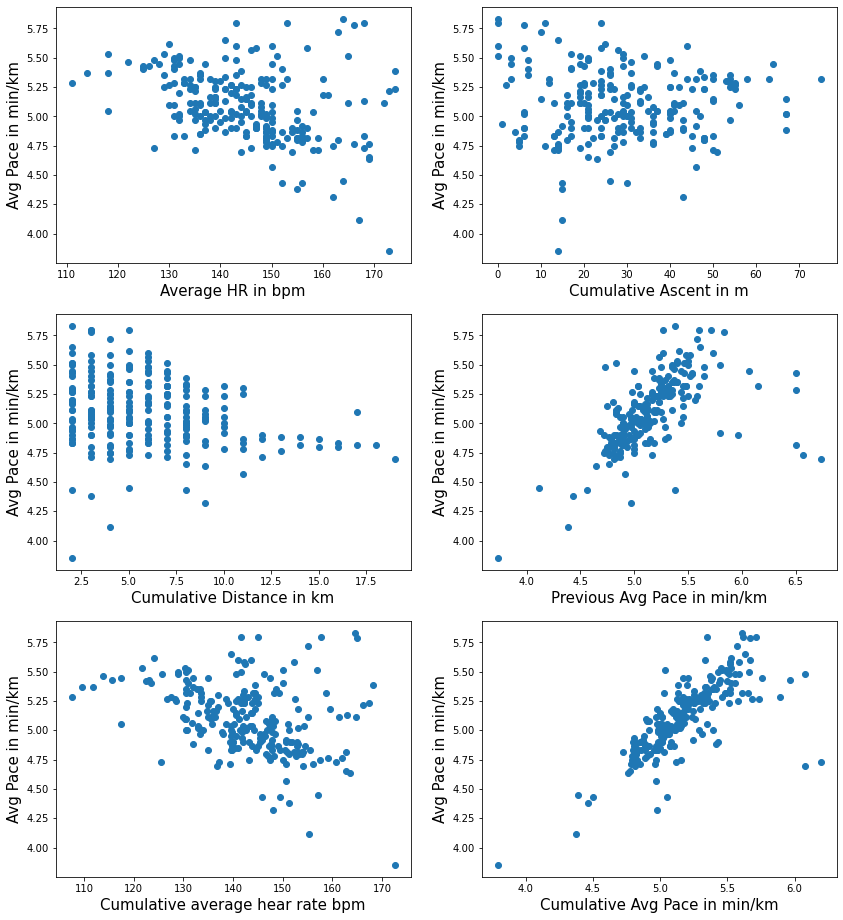

In [3]:
fig, axes = plt.subplots(3, 2, figsize=(14,16)) # create a figure with two axes (1 row,2 columns) on it
axes[0,0].scatter(df['Avg HR'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[0,0].set_xlabel("Average HR in bpm",size=15)
axes[0,0].set_ylabel("Avg Pace in min/km",size=15)

axes[1,0].scatter(df['Cumulative Distance'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[1,0].set_xlabel("Cumulative Distance in km",size=15)
axes[1,0].set_ylabel("Avg Pace in min/km",size=15)

axes[1,1].scatter(df['Previous Avg Pace'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[1,1].set_xlabel("Previous Avg Pace in min/km",size=15)
axes[1,1].set_ylabel("Avg Pace in min/km",size=15)

axes[0,1].scatter(df['Cumulative Ascent'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[0,1].set_xlabel("Cumulative Ascent in m",size=15)
axes[0,1].set_ylabel("Avg Pace in min/km",size=15)

#axes[2,0].scatter(df['Previous Ascent'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
#axes[2,0].set_xlabel("Previous Ascent in m",size=15)
#axes[2,0].set_ylabel("Avg Pace in min/km",size=15) 
# not very representative

axes[2,0].scatter(df['Cumulative Avg HR'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[2,0].set_xlabel("Cumulative average hear rate bpm",size=15)
axes[2,0].set_ylabel("Avg Pace in min/km",size=15)

axes[2,1].scatter(df['Cumulative Avg Pace'],df['Avg Pace']) # plot a scatter plot on axes[0] to show the relation between MinTemp and MaxTemp
axes[2,1].set_xlabel("Cumulative Avg Pace in min/km",size=15)
axes[2,1].set_ylabel("Avg Pace in min/km",size=15)

plt.show()

# Feature Engineering


In [4]:
# X equals "physical load"
avg_hr = df['Avg HR'].to_numpy().reshape(-1,1)
cum_asc = df['Cumulative Ascent'].to_numpy().reshape(-1,1)
cum_dist = df['Cumulative Distance'].to_numpy().reshape(-1,1)
prev_avg_pace = df['Previous Avg Pace'].to_numpy().reshape(-1,1)
# prev_asc = df['Previous Ascent'].to_numpy().reshape(-1,1) Not representative -> Chosen to be left out: Messes up the data
cum_avg_hr = df['Cumulative Avg HR'].to_numpy().reshape(-1,1)
cum_avg_pace = df['Cumulative Avg Pace'].to_numpy().reshape(-1,1)

X = np.append(avg_hr,cum_asc,axis=1)
X = np.append(X,cum_avg_pace,axis=1)
X = np.append(X,cum_dist,axis=1)
X = np.append(X,prev_avg_pace,axis=1)
X = np.append(X,cum_avg_pace,axis=1)

y = df['Avg Pace'].to_numpy()
np.shape(X)

#plt.figure(figsize=(15, 5))    # create a new figure with size 8*6
#plt.scatter(X, y, color='m', s=15, label='datapoints')
#plt.xlabel('physical load',size=15)
#plt.ylabel('Avg Pace',size=15)
#plt.title('Visualization of preprocessed data',size=15) 

#plt.show()

(234, 6)

# Splitting Test Train Validate

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
np.shape(X_train)
#np.shape(y_train)
np.shape(X_val)
#np.shape(y_val)
# Splitting again.


(78, 6)

# Polynomial Model

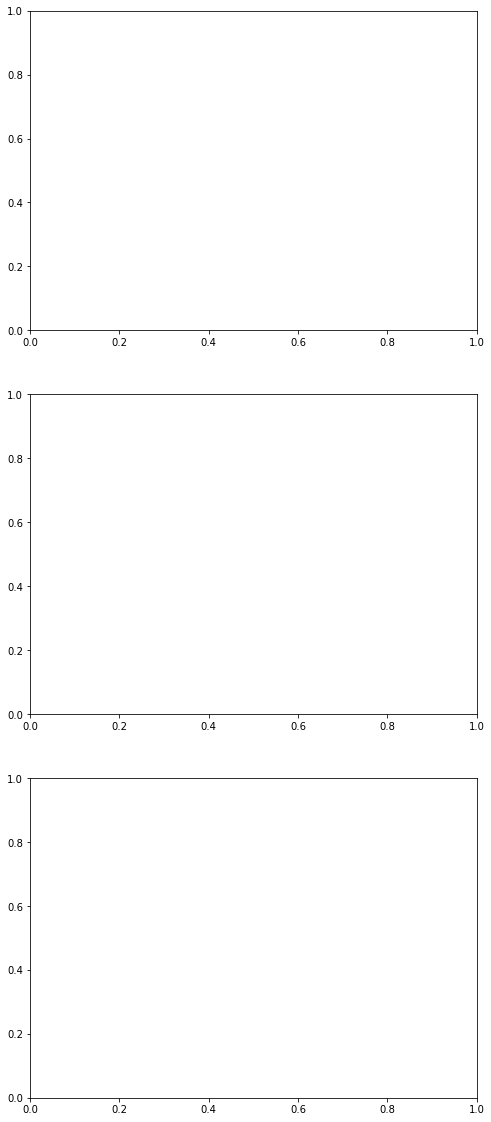

In [7]:
## define a list of values for the maximum polynomial degree 
degrees = [1, 2, 10]    

# we will use this variable to store the resulting training errors for each polynomial degree
tr_errors = []          
val_errors = []

plt.figure(figsize=(8, 20))    # create a new figure with size 8*20
for i, degree in enumerate(degrees):    # use for-loop to fit polynomial regression models with different degrees
    plt.subplot(len(degrees), 1, i + 1)    # choose the subplot
    
    lin_regr = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
 
    poly = PolynomialFeatures(degree=degree)    # generate polynomial features
    X_train_poly = poly.fit_transform(X_train)    # fit and transform the raw features
    lin_regr.fit(X_train_poly, y_train)    # apply linear regression to these new features and labels
    
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train,y_pred_train)
    
    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val,y_pred_val)
    
    tr_errors.append(tr_error)
    val_errors.append(val_error)
    #X_fit = np.linspace(0, 1, 25)    # generate samples
    #plt.tight_layout()
    #plt.plot(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), label="Model")    # plot the polynomial regression model
    #plt.scatter(X_train, y_train, color="b", s=10, label="Train Datapoints")    # plot a scatter plot of y(maxtmp) vs. X(mintmp) with color 'blue' and size '10'
    #plt.scatter(X_val, y_val, color="r", s=10, label="Validation Datapoints")    # do the same for validation data with color 'red'
    #plt.xlabel('mintmp')    # set the label for the x/y-axis
    #plt.ylabel('maxtmp')
    #plt.legend(loc="best")    # set the location of the legend
    #plt.title(f'Polynomial degree = {degree}\nTraining error = {tr_error:.5}\nValidation error = {val_error:.5}')    # set the title
#plt.show()    # show the plot

# Errors
